In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import datetime

2025-11-27 14:36:50.185700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    "./data", 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset="training",
    seed=123,
)

Found 420 files belonging to 11 classes.
Using 294 files for training.


python(7747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./data", 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    validation_split=0.3,
    subset="validation",
    seed=123,
)

Found 420 files belonging to 11 classes.
Using 126 files for validation.


In [4]:
class_names = train_ds.class_names
class_names

['allen key',
 'chisel',
 'file',
 'hammer',
 'mallet',
 'plier',
 'saw',
 'scrapper',
 'screw driver flat',
 'screw driver star',
 'spanner']

2025-11-27 14:37:19.708585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


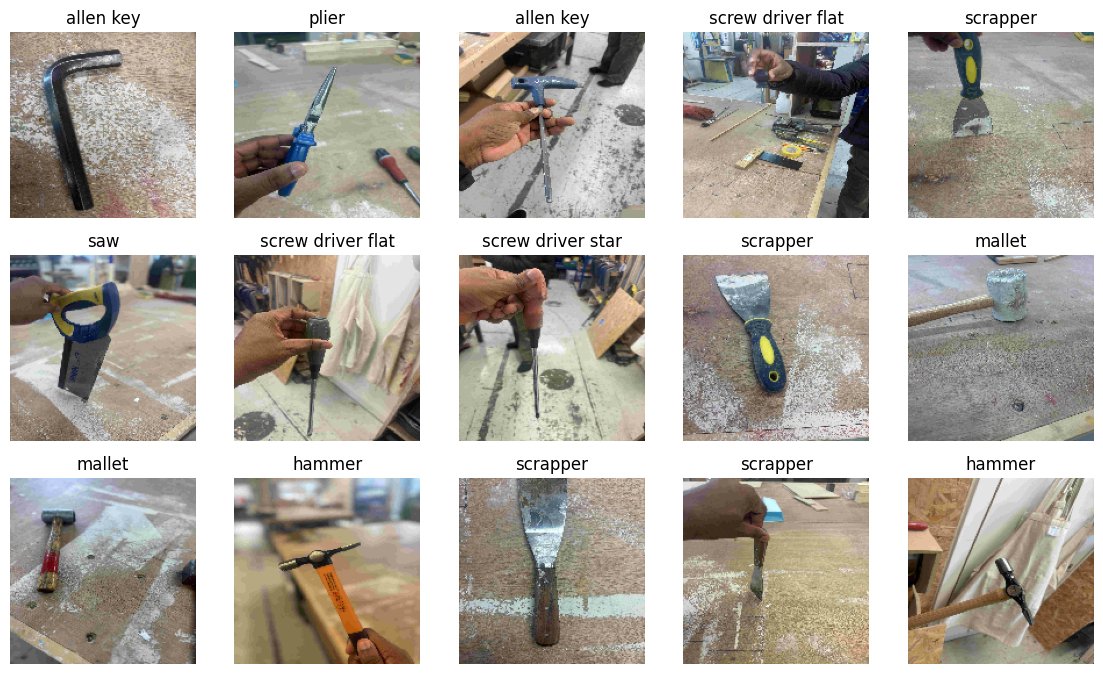

In [5]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Split the validation set into validation and test

test_dataset = val_ds.take(2)
validation_dataset = val_ds.skip(2)

In [7]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 10
Number of validation batches: 2
Number of test batches: 2


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this tutorial.

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2),
])

2025-11-27 14:37:27.384163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


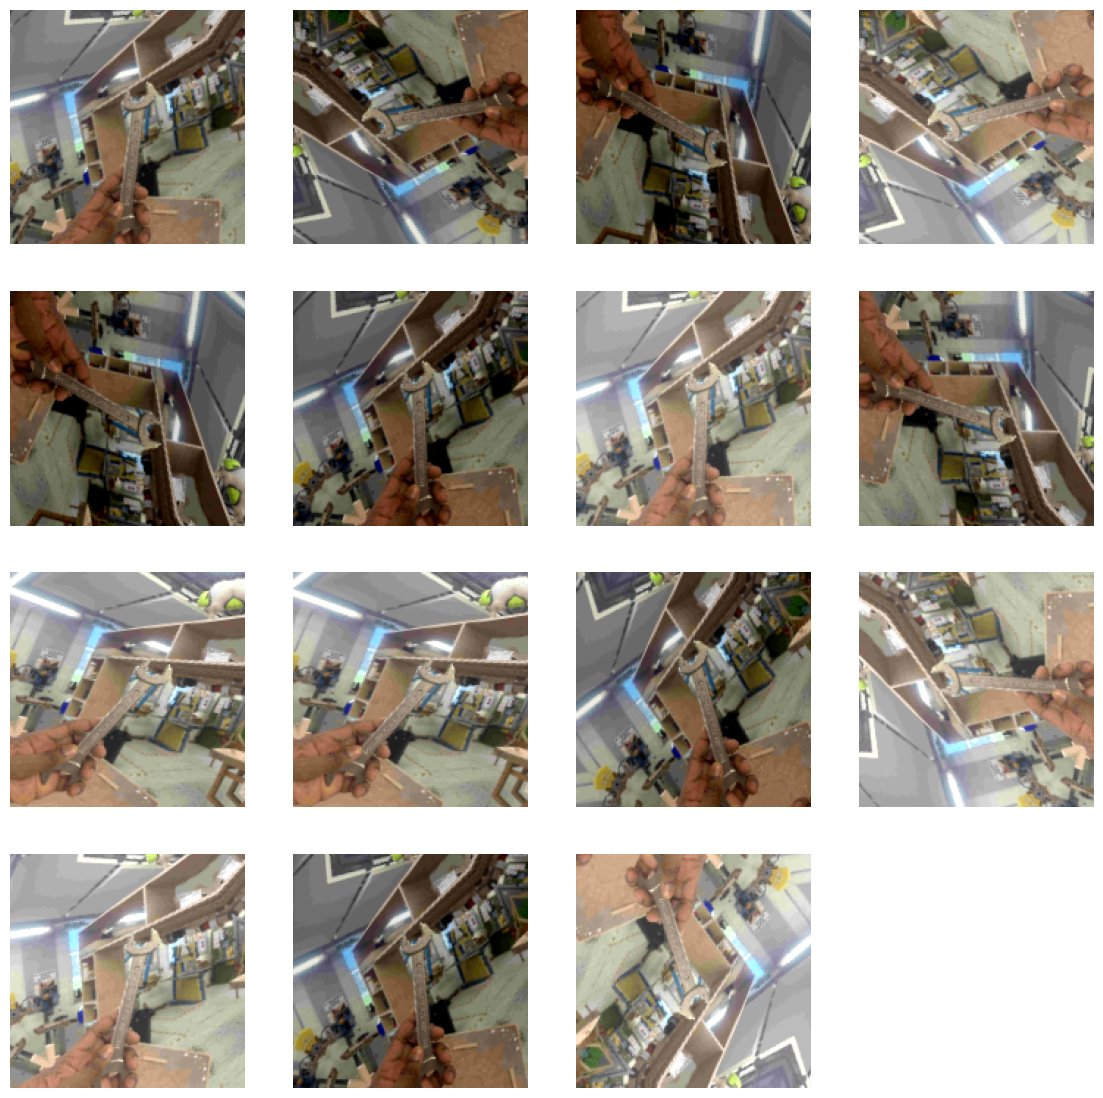

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(14, 14))
  first_image = image[0]
  for i in range(15):
    ax = plt.subplot(4, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Building the models



In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def imagenet_model(is_mobilenet, base_learning_rate):
    rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
    # Create the base model from the pre-trained model MobileNet V2
    IMAGE_SHAPE = IMG_SIZE + (3,)

    if is_mobilenet:
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    else:
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE)
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    image_batch, label_batch = next(iter(train_dataset))
    feature_batch = base_model(image_batch)
    base_model.trainable = False # Freeze all the layers of the model
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(11, activation='softmax')
    prediction_batch = prediction_layer(feature_batch_average)
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

        

### Model Test

In [12]:
learning_rate = 0.0001
mobile_netv2 = imagenet_model(True, learning_rate)
inception_v3 = imagenet_model(False, learning_rate)

In [13]:
initial_epochs = 100

loss0, accuracy0 = mobile_netv2.evaluate(validation_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.0806 - loss: 2.9100


In [14]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.91
initial accuracy: 0.08


In [ ]:
history_mobile_netv2 = mobile_netv2.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=validation_dataset, 
    callbacks=tensorboard_callback
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.1054 - loss: 2.9176 - val_accuracy: 0.0806 - val_loss: 2.7676
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1361 - loss: 2.7590 - val_accuracy: 0.0484 - val_loss: 2.7686
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1565 - loss: 2.5463 - val_accuracy: 0.1129 - val_loss: 2.6034
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1463 - loss: 2.5705 - val_accuracy: 0.0968 - val_loss: 2.7311
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.1531 - loss: 2.5007 - val_accuracy: 0.1452 - val_loss: 2.4456
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1803 - loss: 2.4253 - val_accuracy: 0.0806 - val_loss: 2.7235
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1871 - loss: 2.3357 - val_accuracy: 0.1935 - val_loss: 2.4856
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2177 - loss: 2.2895 - val_accuracy: 0.1613 - v

In [ ]:
history_inception_v3 = inception_v3.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=validation_dataset,
    callbacks=tensorboard_callback
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.0918 - loss: 4.0016 - val_accuracy: 0.1290 - val_loss: 3.0978
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1156 - loss: 3.6278 - val_accuracy: 0.1129 - val_loss: 3.0879
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.0952 - loss: 3.6391 - val_accuracy: 0.1290 - val_loss: 2.9093
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1156 - loss: 3.3512 - val_accuracy: 0.1290 - val_loss: 2.8809
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.1565 - loss: 3.1999 - val_accuracy: 0.1935 - val_loss: 2.5996
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1599 - loss: 2.9788 - val_accuracy: 0.2258 - val_loss: 2.6008
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.1973 - loss: 2.9104 - val_accuracy: 0.1774 - val_loss: 2.4620
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.2619 - loss: 2.5409 - val_accuracy: 0.2742 - v

In [ ]:
def plot_train_val_stat(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    

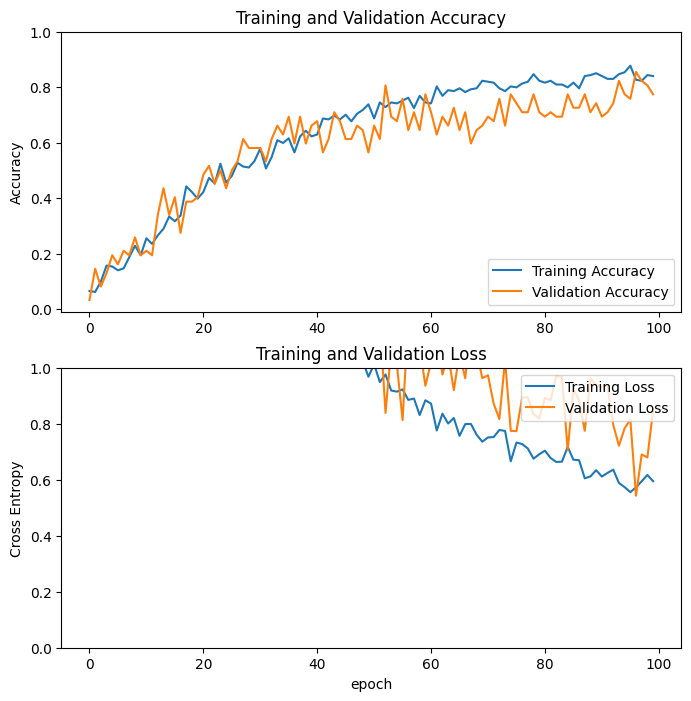

In [ ]:
plot_train_val_stat(history_mobile_netv2)

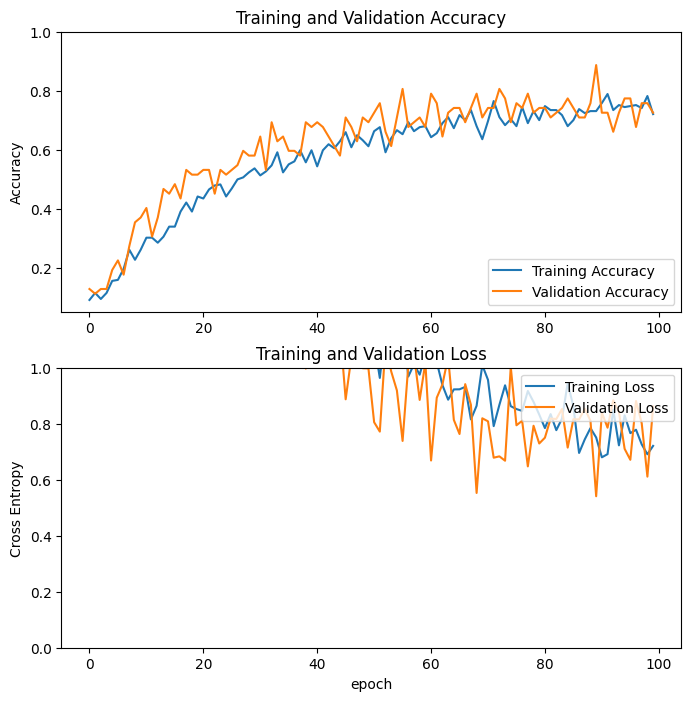

In [ ]:
plot_train_val_stat(history_inception_v3)

In [ ]:
def make_predictions(model):
    loss, accuracy = model.evaluate(test_dataset)
    print('Test accuracy: ', accuracy, "Test loss: ", loss)

    y_pred_probs = model.predict(test_dataset)

    y_pred = np.argmax(y_pred_probs, axis=1)
    
    prediction_val = []
    
    for x in predictions:
        x_list = x.flatten().tolist()
        prediction_val.append(x_list.index(max(x_list)))
    
    print('Predictions:\n', prediction_val)
    print('Labels:\n', label_batch)
    
    plt.figure(figsize=(15, 15))
    for i in range(15):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[prediction_val[i]])
      plt.axis("off")

    return (label_batch, prediction_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8281 - loss: 0.5960
Test accuracy:  0.828125 Test loss:  0.5959978103637695


2025-11-11 16:41:21.688251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
(array([[[[197.      , 112.      , 119.      ],
         [187.      , 102.      , 109.      ],
         [177.      ,  92.      ,  99.      ],
         ...,
         [ 52.      ,  35.      ,  19.      ],
         [ 52.      ,  35.      ,  19.      ],
         [ 52.      ,  35.      ,  19.      ]],

        [[187.      , 102.      , 109.      ],
         [197.      , 112.      , 119.      ],
         [177.      ,  92.      ,  99.      ],
         ...,
         [ 52.      ,  35.      ,  19.      ],
         [ 52.      ,  35.      ,  19.      ],
         [ 52.      ,  35.      ,  19.      ]],

        [[181.45    ,  96.45    , 103.45    ],
         [177.      ,  92.      ,  99.      ],
         [177.      ,  92.      ,  99.      ],
         ...,
         [ 52.      ,  35.      ,  19.      ],
         [ 52.      ,  35.      ,  19.      ],
         [ 28.      ,  28.      ,  28.      ]],

        ...,

        [[128.      , 128.      , 128.      ],
        

TypeError: Invalid shape (32, 160, 160, 3) for image data

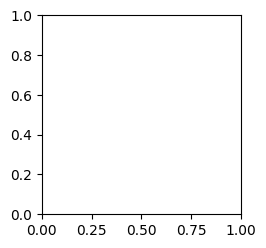

In [ ]:
mobile_netv2_pred = make_predictions(mobile_netv2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6719 - loss: 0.9249
Test accuracy : 0.671875 Test loss : 
Predictions:
 [9, 1, 6, 4, 0, 7, 5, 5, 4, 6, 3, 3, 10, 1, 3, 3, 6, 1, 7, 6, 5, 0, 2, 1, 1, 10, 10, 1, 6, 1, 7, 2]
Labels:
 [ 8  1  6  3  0  7  5  5  4  6  3  3 10  1  3 10  6  1  7  6  5  0  2  1
  1  8 10  8  6  1  7  2]


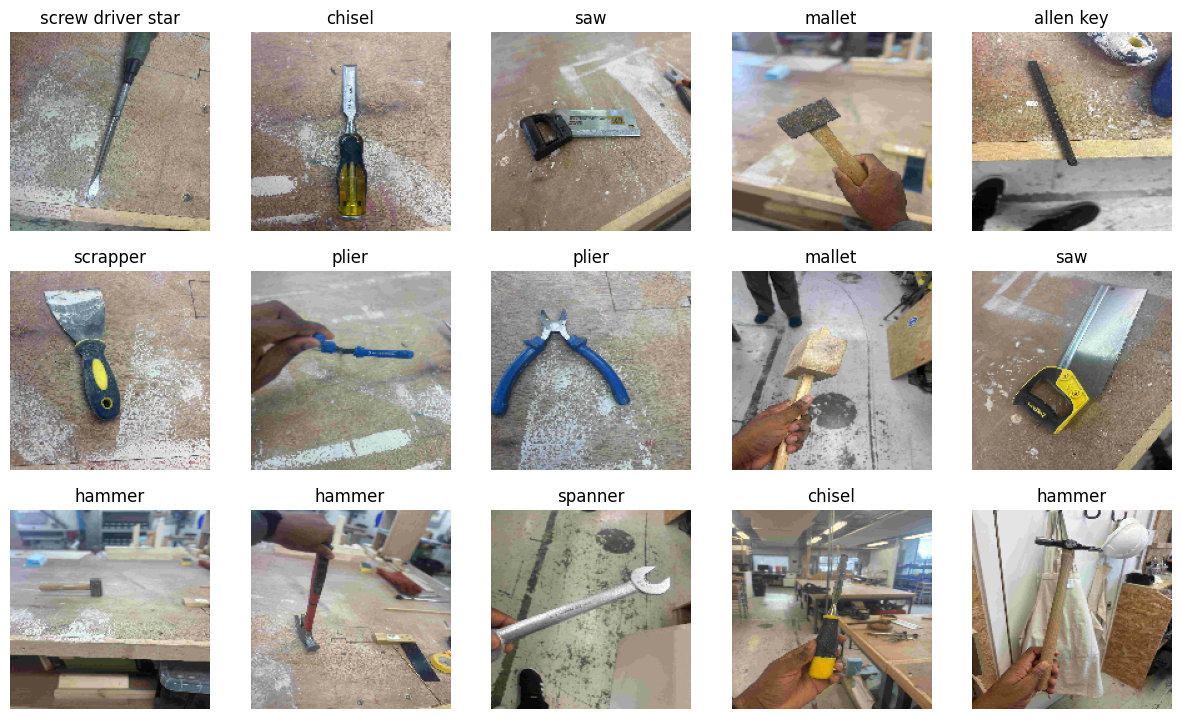

In [ ]:
inception_netv2_pred = make_predictions(inception_v3)

In [ ]:
tf.math.confusion_matrix(
    mobile_netv2_pred[0],
    mobile_netv2_pred[1],
    num_classes=11,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=int32)>

In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)